<small><font color=gray>Notebook author: <a href="https://www.linkedin.com/in/olegmelnikov/" target="_blank">Oleg Melnikov</a> ©2021 onwards</font></small><hr style="margin:0;background-color:silver">

**[<font size=6>👂Phonemes</font>](https://www.kaggle.com/competitions/5feb24jh-phonemes/rules)**. [**Instructions**](https://colab.research.google.com/drive/1riOGrE_Fv-yfIbM5V4pgJx4DWcd92cZr#scrollTo=ITaPDPIQEgXV) for running Colabs.

<small>**(Optional) CONSENT.** <mark>[ X ]</mark> We consent to sharing our Colab (after the assignment ends) with other students/instructors for educational purposes. We understand that sharing is optional and this decision will not affect our grade in any way. <font color=gray><i>(If ok with sharing your Colab for educational purposes, leave "X" in the check box.)</i></font></small>

In [ ]:
from google.colab import drive; drive.mount('/content/drive')   # OK to enable, if your kaggle.json is stored in Google Drive

Mounted at /content/drive


In [ ]:
!pip -q install --upgrade --force-reinstall --no-deps kaggle > log  # upgrade kaggle package (to avoid a warning)
!mkdir -p ~/.kaggle                                           # .kaggle folder must contain kaggle.json for kaggle executable to properly authenticate you to Kaggle.com
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json >log  # First, download kaggle.json from kaggle.com (in Account page) and place it in the root of mounted Google Drive
!cp kaggle.json ~/.kaggle/kaggle.json > log                   # Alternative location of kaggle.json (without a connection to Google Drive)
!chmod 600 ~/.kaggle/kaggle.json                              # give only the owner full read/write access to kaggle.json
!kaggle config set -n competition -v 5feb24jh-phonemes        # set the competition context for the next few kaggle API calls. !kaggle config view - shows current settings
!kaggle competitions download >> log                          # download competition dataset as a zip file
!unzip -o *.zip >> log                                        # Kaggle dataset is copied as a single file and needs to be unzipped.
!kaggle competitions leaderboard --show                     # print public leaderboard

cp: cannot stat 'kaggle.json': No such file or directory
- competition is now set to: 5feb24jh-phonemes
100% 28.8M/28.8M [00:00<00:00, 78.5MB/s]
Using competition: 5feb24jh-phonemes
  teamId  teamName          submissionDate       score         
--------  ----------------  -------------------  ------------  
11635108  7 Phonemes        2024-02-17 23:49:57  0.9372000000  
11633362  8 Phonemes        2024-02-19 00:36:09  0.9346000000  
11631110  6 Phonemes👂       2024-02-18 21:51:09  0.9344000000  
11634763  1 Phonemes        2024-02-18 04:33:04  0.9298000000  
11649235  2 Phonemes        2024-02-19 03:51:46  0.9286000000  
11639045  3 Phonemes        2024-02-19 03:38:48  0.9286000000  
11648828  5 Phonemes        2024-02-19 00:06:53  0.9282000000  
11638724  4 Phonemes        2024-02-18 02:04:36  0.9278000000  
11529795  👂Baseline 🐍(LDA)  2024-01-19 03:51:24  0.6104000000  


In [ ]:
%%time
%%capture
%reset -f
from IPython.core.interactiveshell import InteractiveShell as IS; IS.ast_node_interactivity = "all"
import numpy as np, pandas as pd, time, matplotlib.pyplot as plt, seaborn as sns, os, tqdm, re, sys, cv2, skimage, xgboost, lightgbm as lgb, librosa
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA, LinearDiscriminantAnalysis as LDA
ToCSV = lambda df, fname: df.round(2).to_csv(f'{fname}.csv', index_label='id') # rounds values to 2 decimals

class Timer():
  def __init__(self, lim:'RunTimeLimit'=60): self.t0, self.lim, _ = time.time(), lim, print(f'⏳ started. You have {lim} sec. Good luck!')
  def ShowTime(self):
    msg = f'Runtime is {time.time()-self.t0:.0f} sec'
    print(f'\033[91m\033[1m' + msg + f' > {self.lim} sec limit!!!\033[0m' if (time.time()-self.t0-1) > self.lim else msg)

np.set_printoptions(linewidth=100, precision=2, edgeitems=2, suppress=True)
pd.set_option('display.max_columns', 20, 'display.precision', 2, 'display.max_rows', 4)

CPU times: user 2.66 s, sys: 374 ms, total: 3.04 s
Wall time: 5.46 s


In [ ]:
df = pd.read_csv('XY_Phonemes.csv', low_memory=False); df

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x249,x250,x251,x252,x253,x254,x255,x256,SpkrID,g
0,11.14,15.17,19.12,18.78,13.79,18.98,20.09,19.16,17.32,19.76,...,7.79,10.95,10.05,8.67,10.84,9.50,7.96,9.04,0,NaN
1,10.84,15.20,19.80,17.82,14.10,17.93,19.54,20.97,16.65,22.41,...,12.95,13.05,11.95,11.07,10.81,9.71,11.57,12.22,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59998,12.15,15.78,21.27,19.61,15.14,21.44,23.24,20.91,17.42,21.22,...,8.82,8.00,7.44,8.32,6.51,8.33,6.83,7.02,436,ao
59999,14.78,14.08,15.70,15.51,15.36,15.52,14.68,15.57,15.48,15.45,...,12.87,13.26,13.16,12.65,13.90,13.10,11.16,13.53,436,sh


In [ ]:
df.info()   # observe datatypes and any missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 258 entries, x1 to g
dtypes: float64(256), int64(1), object(1)
memory usage: 118.1+ MB


In [ ]:
# Change string labels to numbers in order of increasing size of the entity (Star < Quasi Star < Galaxy)
# df.Class = df.Class.apply(lambda C: -1 if C=='S' else 0 if C=='Q' else 1 if C=='G' else None)

In [ ]:
vX = df.query('g!=g').drop('g', axis=1)  # slice a test sample (10K observations)
tXY = df.query('g==g')                   # slice training sample
tX, tY = tXY.drop('g', axis=1), tXY.g    # split into training I/O (60K-10K = 50K observation)

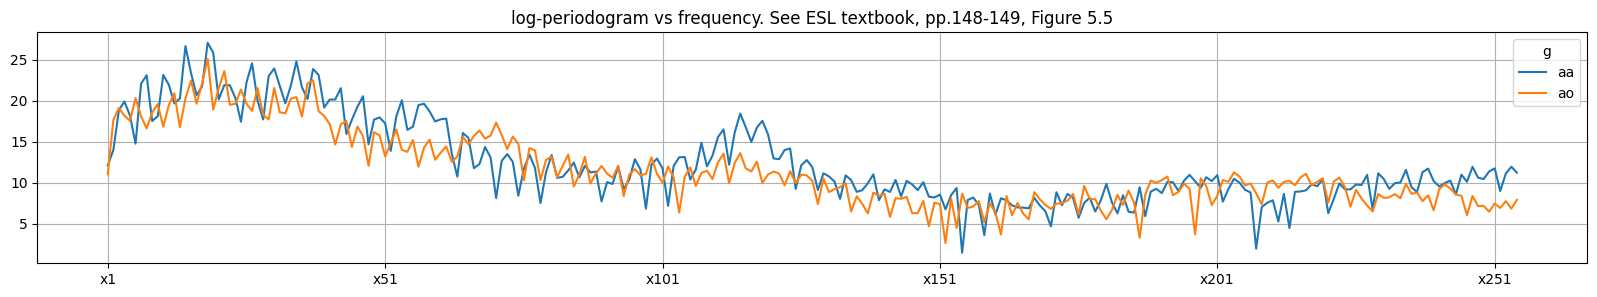

In [ ]:
aa = tXY[tXY.g=='aa'].set_index('g').iloc[[0],0:255]
ao = tXY[tXY.g=='ao'].set_index('g').iloc[[0],0:255]
_ = pd.concat([aa,ao]).T.plot(figsize=(20,3), grid=True, title='log-periodogram vs frequency. See ESL textbook, pp.148-149, Figure 5.5');

In [ ]:
tmr = Timer()

⏳ started. You have 60 sec. Good luck!


<hr color=green size=40>

<strong><font color=green size=5>⏳Timed Green Playground (TGP): Your ideas, code, documentation, and timer START HERE!</font></strong>

<font color=green>Students: Keep all your definitions, code, documentation in <b>TGP</b>. Modifying any code outside of TGP incurs penalties.

<font color=green><h3><b>$\alpha$. Prepare data</b></h3>

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import GridSearchCV
import random
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

In [ ]:
# Attempted to combine samples for the same speaker and class
# def GroupSpkr(X: pd.DataFrame):
#   df = pd.DataFrame([], columns = X.columns)

#   for speaker in X['SpkrID'].unique():
#     for phoneme in ['aa', 'ao', 'dcl', 'iy', 'sh']:
#       averages = X.loc[(X['SpkrID'] == speaker) & (X['g'] == phoneme), :].mean(numeric_only=True)
#       if averages.isnull().values.any():
#         continue
#       averages['g'] = phoneme
#       df.loc[-1] = averages
#       df.index = df.index + 1

#   return df

# Combine frequencies into bins, number of bins should be a divisor of 256
def BinFreq(X: pd.DataFrame, bins):
  bin_size = round(256/bins)
  for bin in range(bins):
    X['bin' + str(bin)] = X["x" + str(bin_size * bin + 1)]
    X.drop(["x" + str(bin_size * bin + 1)], axis=1, inplace=True)
    for i in range(2, bin_size+1):
      if (bin_size * bin + i) > 256:
        return X
      X['bin' + str(bin)] += X["x" + str(bin_size * bin + i)]
      X.drop(["x" + str(bin_size * bin + i)], axis=1, inplace=True)

  return X

In [ ]:
%%time
n = 5000   # validation subsample

# Bin frequencies
tXYgrouped = BinFreq(tXY.copy(), 64)
vX = BinFreq(vX.copy(), 64)

tXg, tYg = tXYgrouped.drop('g', axis=1).iloc[:50000-n,:], tXYgrouped.g[:50000-n]

# Validation set
vXg, vYg = tXYgrouped.drop('g', axis=1), tXYgrouped.g
vXg, vYg = vXg.iloc[-n:,:], vYg[-n:]

tXg.drop(["SpkrID"], axis=1, inplace=True)
vXg.drop(["SpkrID"], axis=1, inplace=True)
vX.drop(["SpkrID"], axis=1, inplace=True)

CPU times: user 6.55 s, sys: 1.93 s, total: 8.48 s
Wall time: 13.8 s


<font color=green><h3><b>$\beta$. Fit the model to the training dataset</b><h3>

In [ ]:
random.seed(0)
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ('pca', PCA(n_components='mle')),
    ("predict", StackingClassifier([('lda', LDA(n_components=2)), ('dt', DecisionTreeClassifier(max_depth=7, min_samples_leaf=10, random_state=42))]) )
])
pipeline.fit(tXg, tYg)
# Code used for testing models / class reports
# y_pred = pipeline.predict(vXg)
# print(classification_report(vYg, y_pred))
# print(pipeline.score(vXg, vYg))


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components='mle')),
                ('predict',
                 StackingClassifier(estimators=[('lda',
                                                 LinearDiscriminantAnalysis(n_components=2)),
                                                ('dt',
                                                 DecisionTreeClassifier(max_depth=7,
                                                                        min_samples_leaf=10,
                                                                        random_state=42))]))])

In [ ]:
# Test models with cross-validation
#cross_val_score(pipeline, tXg, tYg, cv=5)
# yPred = cross_val_predict(pipeline, tXg, tYg, cv=5)
# print(len(tXg))
# accuracy_score(tYg[:9000], yPred[:9000])
# accuracy_score(tYg[9000:18000], yPred[9000:18000])
# accuracy_score(tYg[18000:27000], yPred[18000:27000])
# accuracy_score(tYg[27000:36000], yPred[27000:36000])
# accuracy_score(tYg[36000:45000], yPred[36000:45000])

<font color=green><h3><b>$\gamma$. Generate predictions</b><h3>

In [ ]:
#pipeline.fit(tXg, tYg)
pY = pd.DataFrame(pipeline.predict(vX), index=range(1,len(vX)+1), columns=['g'])  # ensure that labels and observations are in corresponding order
pd.DataFrame(df.g.fillna('unknown').value_counts(sort=False)).rename(columns={'g':'observed output g'}).T   # distribution of all train labels
pd.DataFrame(pY.value_counts(sort=False)).rename(columns={0:'predicted output g'}).T
ToCSV(pY, 'freqbin64-stack-lda-dt710-noid-pca')

,unknown,aa,ao,dcl,sh,iy
observed output g,10000,7635,11197,8340,9674,13154


g,aa,ao,dcl,iy,sh
predicted output g,1372,2411,1632,2624,1961


In [ ]:
# Code to create LDA graph
# lda = LDA(n_components=2)
# x_trans = lda.fit_transform(tX, tY)
# #pred = lda.predict(vX0)
# print(x_trans)


# plt.figure()
# classes = ["aa", "ao", "dcl", "iy", "sh"]
# colors = ["blue", "olive", "cyan", "red", "green"]
# lw = 2

# for color, cls in zip(colors, classes):
#     plt.scatter(x_trans[tY == cls, 0], x_trans[tY == cls, 1], color=color, alpha=0.8, lw=lw, label=cls)

# plt.legend(loc="best", scatterpoints=1)
# plt.show()

LDA class comparison graph

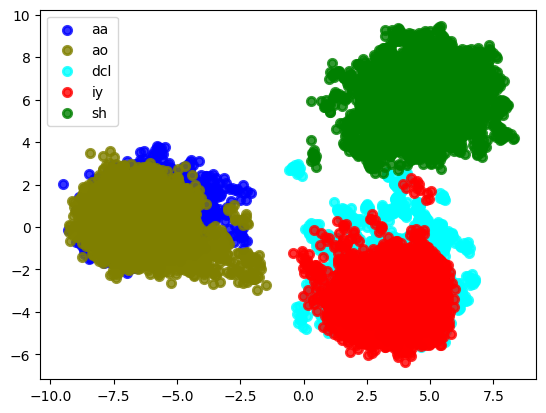

<font color=green><h3><b>$\epsilon$. Documentation</b></h3></font>

<font color=green><h4><b>Task 1. Explain Decisions in Preprocessing Pipeline</b></h4></font>

<font color=green>
Explain elements of your preprocessing pipeline i.e. feature engineering, subsampling, clustering, dimensionality reduction, etc.</font>

<font color=green>

1. Why did you choose these elements? (Something in EDA, prior experience,...? Note: EDA is not required)
1. How do you evaluate the effectiveness of these elements?
1. What else have you tried that worked or didn't?

</font>

This dataset has 60000 observation and 257 features. Our first goal was to select an appropriate number of rows (through sampling) and features for downstream processing. To select rows, we initially experimented with various forms of sampling to determine its impact to several modeling techniques. We explored different degrees of stratified sampling (maintaining class distribution) and balanced sampling (selecting equal observations from each class). At a later juncture, where we recognized the challenges with separating the phenomes 'ao' and 'aa', we attempted oversampling using a library called SMOTE to create more instances of these classes in an attempt to force the model to learn these features. For feature engineering we first attempted to remove outliers by Local Outlier Removal technique and Inter Quartile Range method. We also attempted different transforms of the data, attempting to evaluate different characteristics of the audio such as frequency and energy. Boxplots were evaluated to determine the separability of the classes against these feautures and some showed promise however once tested again several different modeling techniques, what consistently demonstrated the best performance was actually including no additional features but sorting the data by SpkrID so that each set of examples from each speaker is presented to the model for training consecutively.

After these attempts at a more traditional approach, our team did some research on classification of audio data and found an interesting paper on Penalized Linear Discriminant Analysis (PDA) using Natural Cubic Spline Transformation[5]. We attempted to use these techniques specifically to capture differences in 'ao' and 'ai' phenomes. As noted, the model seemed to have the most difficultly  distinguishing between these two phenomes, with precision, recall, and f1-scores usually hovering between 88-92, while scores for other phenomes averaged 98 and 99 for our top performing models. PDA penalizes discriminant coefficients to enforce smoothness based on frequency. Smoothing splines are a regression technique used to fit a smooth curve to data by penalizing local contrasts such as second-order differences, thereby enforcing smoothness. They are subsets of Piecewise linear basis functions which are used in modeling to represent functions as a combination of linear segments, enabling the approximation of complex curves. Although this exploration of PDA assisted us in exploring the data in some interesting ways it ultimately did not perform better than our discovery of simply grouping speakers so after some initial experimation we reverted to our initial approach.

Our final approach utilized a binning method, which combined the data features into bins. Since each feature (x1-x256) gives the presence of a frequency (as the data is a periodogram), combining nearby frequencies reduces overfitting due to speaker voice variance and greatly increased the distinction between aa and ao.

<font color=green><h4><b>Task 2. Explain Decisions in Modeling Pipeline</b></h4></font>

<font color=green>
Explain your modeling approach, i.e. ideas you tried and why you thought they would be helpful.

1. How did these decisions guide you in modeling?
1. How do you evaluate the effectiveness of these elements?
1. What else have you tried that worked or didn't?

</font>

We tried many different models and variations during testing. For normalization, we tried out standard scaler, minmax scaling, and quantile scaling. We also tried out most of the ensemble methods and estimators allowed in the ruleset, logistic regression, decision trees, random forest, bagging, LDA, and SVM. To evaluate the effectiveness of the models, we used both cross validation, validation set test runs, and the kaggle submissions. Ocassionally, we would acheive impressive accuracy, precision, recall and f1 scores (more than 0.95 for all five classes) upon fitting on tX. However, these higher numbers sometimes did not translate into a great kaggle score. The reason might be models overfitting and hence not generalizing on vX values.

Finally, we settled on a pipeline consisting of standard scalar, PCA dimension reduction, and a stacking classifier using Linear Discriminant Analysis (LDA) and a Decision tree classifer, with a final Logistic Regression estimator. This combination netted us the highest accuracy in the end while allowing us to run the notebook within the time limit. It should be noted that some models scored higher but could not run within the time limit and thus our final submission includes the stacking approach explained above per the rules of the competition.

Choosing the models included a fair amount of trial and error, but we determined early on that LDA did an excellent job of separating dcl/sh, iy, and aa/ao into subgroups. This led us to use an ensemble method with LDA to sort into subgroups, and a decision tree to separate into classes. Both stacking and voting classifiers were tested, but stacking consistently showed better results. After this, most of the effort was spent on hyperparameter tuning.

<font color=green><h3><b>$\zeta$. References</b></h3></font>

<font color=green>
Cite your sources to help your peers learn from these (and to avoid plagiarism claims). At the least, HOML textbook should be cited. Use Google Scholar to draw APA citation format for books and publications. Also cite StackOverflow, package documentation, and other meaningful internet resources.

1. Géron, A. (2019). Hands-on machine learning with Scikit-learn, Keras, and Tensorflow: Concepts, tools, and techniques to build intelligent systems (2nd edition). O'Reilly Media.
1. Hastie, T., Tibshirani, R., Friedman, J. H., & Friedman, J. H. (2009). The elements of statistical learning: data mining, inference, and prediction (Vol. 2, pp. 1-758). New York: springer.
1. Hastie, T., Buja, A., & Tibshirani, R. (1995). Penalized discriminant analysis. The Annals of Statistics, 23(1), 73-102.
1. Oleg Melnikov. (2024). 5feb24jh-👂Phonemes Kaggle. Rules. https://www.kaggle.com/competitions/5feb24jh-phonemes/rules
1. Witten, D. M., & Tibshirani, R. (2011). Penalized classification using Fisher’s linear discriminant. Journal of the Royal Statistical Society Series B: Statistical Methodology, 73(5), 753-772.

Packages:
1. Imblearn.over_sampling.RandomOverSampler. imbalanced-learn. (n.d.-a). https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.RandomOverSampler.html
1. Imblearn.over_sampling.SMOTE. imbalanced-learn. (n.d.-b). https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html
1. Sklearn.base.BaseEstimator. scikit. (n.d.-c). https://scikit-learn.org/stable/modules/generated/sklearn.base.BaseEstimator.html
1. Sklearn.base.TransformerMixin. scikit. (n.d.-d). https://scikit-learn.org/stable/modules/generated/sklearn.base.TransformerMixin.html
1. Sklearn.compose.ColumnTransformer. scikit. (n.d.-e). https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html
1. Sklearn.decomposition.PCA. scikit. (n.d.-f). https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
1. Sklearn.ensemble.AdaBoostClassifier. scikit. (n.d.-g). https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html
1. Sklearn.ensemble.BaggingClassifier. scikit. (n.d.-h). https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html
1. Sklearn.ensemble.ExtraTreesClassifier. scikit. (n.d.-i). https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html
1. Sklearn.ensemble.GradientBoostingClassifier. scikit. (n.d.-j). https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html
1. Sklearn.ensemble.RandomForestClassifier. scikit. (n.d.-k). https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
1. Sklearn.ensemble.StackingClassifier. scikit. (n.d.-l). https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html
1. Sklearn.ensemble.VotingClassifier. scikit. (n.d.-m). https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html
1. Sklearn.metrics.accuracy_score. scikit. (n.d.-n). https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html
1. Sklearn.metrics.classification_report. scikit. (n.d.-o). https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html
1. Sklearn.model_selection.cross_validate. scikit. (n.d.-p). https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html
1. Sklearn.model_selection.cross_val_predict. scikit. (n.d.-q). https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html
1. Sklearn.model_selection.cross_val_score. scikit. (n.d.-r). https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html
1. Sklearn.model_selection.GridSearchCV. scikit. (n.d.-s). https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
1. Sklearn.neighbors.KNeighborsClassifier. scikit. (n.d.-t). https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
1. Sklearn.pipeline.Pipeline. scikit. (n.d.-u). https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html
1. Sklearn.preprocessing.MinMaxScaler. scikit. (n.d.-v). https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
1. Sklearn.preprocessing.QuantileTransformer. scikit. (n.d.-w). https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.QuantileTransformer.html
1. Sklearn.preprocessing.StandardScaler. scikit. (n.d.-x). https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
1. Sklearn.svm.LinearSVC. scikit. (n.d.-y). https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html
1. Sklearn.svm.NuSVC. scikit. (n.d.-z). https://scikit-learn.org/stable/modules/generated/sklearn.svm.NuSVC.html
1. Sklearn.svm.SVC. scikit. (n.d.-aa). https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
1. Sklearn.tree.DecisionTreeClassifier. scikit. (n.d.-ab). https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html


<font size=5>⌛</font> <strong><font color=green size=5>Do not exceed competition's runtime limit! Do not write code outside TGP</font></strong>
<hr color=green size=40>

In [ ]:
tmr.ShowTime()    # measure Colab's runtime. Do not remove. Keep as the last cell in your notebook.

Runtime is 36 sec


## 💡**Starter Ideas**

1. Tune model hyperparameters
1. Try smarter sampling from the training set to avoid using all observations (due to time constraint) and, instead, develop more features
1. Try feature restriction, selection, and regularization (see ESL pp.140-141)
1. Do a thorough EDA: look for feature augmentations that result in linear decision boundaries between pairs of classes.
1. Try encoding and/or incorporating speaker ID. For example, you could scale/transform each speaker's observations separately.
1. Carefully read the example in [ESL textbook, p.149](https://hastie.su.domains/ElemStatLearn/printings/ESLII_print12.pdf#page=168), check seminar Colab and lecture slides
1. Check difference in distribution between test and train data. You might consider [group k-fold](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection) for testing locally or your model will memorize user-phoneme releation, instead of phoneme attributes and class.
1. Learn the domain to develop better features. See ["Penalized discriminant analysis"](https://scholar.google.com/scholar?hl=en&as_sdt=0%2C48&q=Penalized+Discriminant+Analysis&btnG=)
1. Look for training outliers that can affect your model's test performance.
  1. Essentially, you need to find and exclude training [influential points](https://en.wikipedia.org/wiki/Influential_observation), but training outliers might be influential
  1. Brute force with [LOOCV](https://en.wikipedia.org/wiki/Cross-validation_(statistics)#Leave-one-out_cross-validation) is slow, but robust. You might find methods to find each training point's contribution to the prediction and remove rare extreme contributors (since they may not be in the test set)
  1. You can find outliers; then evaluate their effect on model's performance
    1. You can evaluate 1D and 2D histograms to find outliers and
    1. You can cluster observations and find outliers that don't fit the clusters (DBSCAN may be helpful)
    1. You can compress high dimensional space to 1D (with PCA, tSNE, UMAP) and then find outliers with a histogram
 1. Additional info:
    1. Harmonics: [wiki](https://en.wikipedia.org/wiki/Harmonic), [sinusoidal regression](https://www.youtube.com/results?search_query=regression+sinusoidal)
    1. Discrete Fourier Transofrm (DFT): [wiki](https://en.wikipedia.org/wiki/Discrete_Fourier_transform), [Steve Brunton @UW](https://www.youtube.com/watch?v=nl9TZanwbBk), [YouTube search](https://www.youtube.com/results?search_query=Discrete+Fourier+transform)
    1. Spectral density estimation [(wiki)](https://en.wikipedia.org/wiki/Spectral_density_estimation), [YouTube search](https://www.youtube.com/results?search_query=spectral+density+estimation)


